In [40]:
import requests
import pandas as pd
from pymongo import MongoClient, UpdateOne
import json
import requests
import time
from config import api_key_zip, api_key_census
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr
import seaborn as sns


In [4]:
# Create a new database to hold copies of collections as to not interfere with data in the original collections
# MongoDB connection URI
mongo_uri = "mongodb://localhost:27017/"
mongo = MongoClient(mongo_uri)

# Connect to the original database
db = mongo.chicago_bikes

# Connect to the collections in the original database
start_stations_original = db['Top10StartStations']
end_stations_original = db['Top10EndStations']

# Connect to the new database
db2 = mongo["chicago_bikes_copy"]

# Specify the names of the new collections
new_start_collection_name = 'Top10StartStationsCopy'
new_end_collection_name = 'Top10EndStationsCopy'

# Drop existing collections with the same names in the new database (if needed)
db2[new_start_collection_name].drop()
db2[new_end_collection_name].drop()

# Create new collections in the new database that's a copy of the original database
db2[new_start_collection_name].insert_many(start_stations_original.find())
db2[new_end_collection_name].insert_many(end_stations_original.find())

# Print each document in the new start stations collection to verify the data transfer
print(f"Documents in {new_start_collection_name}:")
for doc in db2[new_start_collection_name].find():
    print(doc)

# Print each document in the new end stations collection to verify the data transfer
print(f"\nDocuments in {new_end_collection_name}:")
for doc in db2[new_end_collection_name].find():
    print(doc)

Documents in Top10StartStationsCopy:
{'_id': 'Streeter Dr & Grand Ave', 'count': 71269, 'latitude': 41.880958, 'longitude': -87.616743}
{'_id': 'DuSable Lake Shore Dr & Monroe St', 'count': 39251, 'latitude': 41.867888, 'longitude': -87.623041}
{'_id': 'DuSable Lake Shore Dr & North Blvd', 'count': 37698, 'latitude': 41.897448, 'longitude': -87.628722}
{'_id': 'Michigan Ave & Oak St', 'count': 37208, 'latitude': 41.869265218438194, 'longitude': -87.67373085021973}
{'_id': 'Wells St & Concord Ln', 'count': 34508, 'latitude': 41.897448, 'longitude': -87.628722}
{'_id': 'Millennium Park', 'count': 32849, 'latitude': 41.8810317, 'longitude': -87.62408432}
{'_id': 'Clark St & Elm St', 'count': 32560, 'latitude': 41.920771, 'longitude': -87.663712}
{'_id': 'Kingsbury St & Kinzie St', 'count': 31614, 'latitude': 41.893992, 'longitude': -87.629318}
{'_id': 'Theater on the Lake', 'count': 31283, 'latitude': 41.926277, 'longitude': -87.630834}
{'_id': 'Wells St & Elm St', 'count': 28978, 'latitu

In [5]:
# LocationIQ API setup to find the zip codes for each station
api_key_locationiq = api_key_zip

# Function to get zip code using LocationIQ
def get_zip_code(latitude, longitude, api_key):
    url = f"https://us1.locationiq.com/v1/reverse.php?key={api_key}&lat={latitude}&lon={longitude}&format=json"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data.get("address", {}).get("postcode")
    else:
        print(f"Error retrieving ZIP code for {latitude}, {longitude}: {response.text}")
        return None

# Function to update ZIP codes in MongoDB collection
def update_zip_codes(collection_name):
    collection = db2[collection_name]
    for station in collection.find():
        lat = station.get("latitude")
        lon = station.get("longitude")
        zip_code = get_zip_code(lat, lon, api_key_locationiq)
        if zip_code:
            collection.update_one({'_id': station['_id']}, {'$set': {'zip_code': zip_code}})
            print(f"Updated ZIP code for station {station['_id']} at ({lat}, {lon}) to {zip_code}")
        else:
            print(f"No ZIP code found for station {station['_id']} at ({lat}, {lon})")

        # Delay for 1 second to comply with API rate limits
        time.sleep(1)

# Update ZIP codes for Top 10 Start and End Stations
update_zip_codes('Top10StartStationsCopy')
update_zip_codes('Top10EndStationsCopy')

Updated ZIP code for station Streeter Dr & Grand Ave at (41.880958, -87.616743) to 60601
Updated ZIP code for station DuSable Lake Shore Dr & Monroe St at (41.867888, -87.623041) to 60605
Updated ZIP code for station DuSable Lake Shore Dr & North Blvd at (41.897448, -87.628722) to 60654
Updated ZIP code for station Michigan Ave & Oak St at (41.869265218438194, -87.67373085021973) to 60612
Updated ZIP code for station Wells St & Concord Ln at (41.897448, -87.628722) to 60654
Updated ZIP code for station Millennium Park at (41.8810317, -87.62408432) to 60601
Updated ZIP code for station Clark St & Elm St at (41.920771, -87.663712) to 60614
Updated ZIP code for station Kingsbury St & Kinzie St at (41.893992, -87.629318) to 60654
Updated ZIP code for station Theater on the Lake at (41.926277, -87.630834) to 60657
Updated ZIP code for station Wells St & Elm St at (41.893992, -87.629318) to 60654
Updated ZIP code for station Streeter Dr & Grand Ave at (41.892278, -87.612043) to 60611
Updated

In [6]:
# Make sure the zip codes were added to db2's collections
# Collections names
new_start_collection_name = 'Top10StartStationsCopy'
new_end_collection_name = 'Top10EndStationsCopy'

# Connect to the collections in the new database
new_start_collection = db2[new_start_collection_name]
new_end_collection = db2[new_end_collection_name]

# Print documents in Top10StartStationsCopy
print(f"Documents in {new_start_collection_name}:")
for doc in new_start_collection.find():
    print(doc)

# Print documents in Top10EndStationsCopy
print(f"\nDocuments in {new_end_collection_name}:")
for doc in new_end_collection.find():
    print(doc)

Documents in Top10StartStationsCopy:
{'_id': 'Streeter Dr & Grand Ave', 'count': 71269, 'latitude': 41.880958, 'longitude': -87.616743, 'zip_code': '60601'}
{'_id': 'DuSable Lake Shore Dr & Monroe St', 'count': 39251, 'latitude': 41.867888, 'longitude': -87.623041, 'zip_code': '60605'}
{'_id': 'DuSable Lake Shore Dr & North Blvd', 'count': 37698, 'latitude': 41.897448, 'longitude': -87.628722, 'zip_code': '60654'}
{'_id': 'Michigan Ave & Oak St', 'count': 37208, 'latitude': 41.869265218438194, 'longitude': -87.67373085021973, 'zip_code': '60612'}
{'_id': 'Wells St & Concord Ln', 'count': 34508, 'latitude': 41.897448, 'longitude': -87.628722, 'zip_code': '60654'}
{'_id': 'Millennium Park', 'count': 32849, 'latitude': 41.8810317, 'longitude': -87.62408432, 'zip_code': '60601'}
{'_id': 'Clark St & Elm St', 'count': 32560, 'latitude': 41.920771, 'longitude': -87.663712, 'zip_code': '60614'}
{'_id': 'Kingsbury St & Kinzie St', 'count': 31614, 'latitude': 41.893992, 'longitude': -87.629318, 

In [7]:
# Add population data back with Top 10 Start Stations and Top 10 End Stations collections

# Connect to collections
start_stations_collection = db2.Top10StartStationsCopy
end_stations_collection = db2.Top10EndStationsCopy

# Retrieve the population data for each ZIP code from the census API
def get_population_data(api_key_census, zip_codes):
    population_data = {}
    for zip_code in zip_codes:
        # Construct the API request URL
        response = requests.get(
            f"https://api.census.gov/data/2019/acs/acs5",
            params={
                'get': 'B01003_001E',
                'for': f'zip code tabulation area:{zip_code}',
                'in': 'state:17',  # Illinois state code
                'key': api_key_census
            }
        )
        if response.status_code == 200:
            data = response.json()
            # Extract the population count and update the population_data dictionary
            population_data[zip_code] = int(data[1][0])
        else:
            print(f"Failed to retrieve data for ZIP code {zip_code}: {response.text}")
    
    return population_data

# Function to update the station documents with population data
def update_stations_with_population(collection, population_data):
    for zip_code, population in population_data.items():
        # Update documents in the collection with the matching ZIP code
        result = collection.update_many(
            {'zip_code': zip_code},
            {'$set': {'population': population}}
        )
        print(f"Updated {result.modified_count} documents in collection '{collection.name}' with ZIP code {zip_code} to population {population}")

# Retrieve a list of unique ZIP codes from both collections, safely checking for the 'zip_code' field
relevant_zip_codes = []
for collection in [start_stations_collection, end_stations_collection]:
    for doc in collection.find():
        zip_code = doc.get('zip_code')
        if zip_code:
            relevant_zip_codes.append(zip_code)
relevant_zip_codes = list(set(relevant_zip_codes))  # Remove duplicates

# Retrieve population data for the relevant ZIP codes
population_data = get_population_data(api_key_census, relevant_zip_codes)

# Update the collections with the population data
update_stations_with_population(start_stations_collection, population_data)
update_stations_with_population(end_stations_collection, population_data)

Updated 1 documents in collection 'Top10StartStationsCopy' with ZIP code 60612 to population 33735
Updated 1 documents in collection 'Top10StartStationsCopy' with ZIP code 60614 to population 71954
Updated 0 documents in collection 'Top10StartStationsCopy' with ZIP code 60611 to population 33224
Updated 0 documents in collection 'Top10StartStationsCopy' with ZIP code 60610 to population 40548
Updated 1 documents in collection 'Top10StartStationsCopy' with ZIP code 60605 to population 29060
Updated 4 documents in collection 'Top10StartStationsCopy' with ZIP code 60654 to population 20022
Updated 2 documents in collection 'Top10StartStationsCopy' with ZIP code 60601 to population 15083
Updated 1 documents in collection 'Top10StartStationsCopy' with ZIP code 60657 to population 70958
Updated 0 documents in collection 'Top10EndStationsCopy' with ZIP code 60612 to population 33735
Updated 2 documents in collection 'Top10EndStationsCopy' with ZIP code 60614 to population 71954
Updated 2 docu

In [8]:
# Ensure population was added to db2's collections
# Connect to the collections
start_collection = db2['Top10StartStationsCopy']
end_collection = db2['Top10EndStationsCopy']

# Function to print all fields of sample documents
def print_sample_documents(collection, collection_name):
    print(f"\nSample documents from {collection_name}:")
    sample_docs = collection.find() 
    for doc in sample_docs:
        print(doc)

# Print sample documents from both collections
print_sample_documents(start_collection, 'Top10StartStationsCopy')
print_sample_documents(end_collection, 'Top10EndStationsCopy')


Sample documents from Top10StartStationsCopy:
{'_id': 'Streeter Dr & Grand Ave', 'count': 71269, 'latitude': 41.880958, 'longitude': -87.616743, 'zip_code': '60601', 'population': 15083}
{'_id': 'DuSable Lake Shore Dr & Monroe St', 'count': 39251, 'latitude': 41.867888, 'longitude': -87.623041, 'zip_code': '60605', 'population': 29060}
{'_id': 'DuSable Lake Shore Dr & North Blvd', 'count': 37698, 'latitude': 41.897448, 'longitude': -87.628722, 'zip_code': '60654', 'population': 20022}
{'_id': 'Michigan Ave & Oak St', 'count': 37208, 'latitude': 41.869265218438194, 'longitude': -87.67373085021973, 'zip_code': '60612', 'population': 33735}
{'_id': 'Wells St & Concord Ln', 'count': 34508, 'latitude': 41.897448, 'longitude': -87.628722, 'zip_code': '60654', 'population': 20022}
{'_id': 'Millennium Park', 'count': 32849, 'latitude': 41.8810317, 'longitude': -87.62408432, 'zip_code': '60601', 'population': 15083}
{'_id': 'Clark St & Elm St', 'count': 32560, 'latitude': 41.920771, 'longitude

In [9]:
mongo.close()

In [10]:
# Save data as a .json file
# MongoDB setup
mongo_uri = "mongodb://localhost:27017/"
mongo = MongoClient(mongo_uri)
db2 = mongo["chicago_bikes_copy"]
# Collection from which to extract data
collection = db2['Top10StartStationsCopy']

# Extract data
data = list(collection.find({}))

# Save to a JSON file
with open('Top10StartStationsCopy.json', 'w', encoding='utf-8') as file:
    json.dump(data, file, ensure_ascii=False, indent=4)

In [11]:
mongo.close()

In [12]:
# Save data as a .json file
# MongoDB setup
mongo_uri = "mongodb://localhost:27017/"
mongo = MongoClient(mongo_uri)
db2 = mongo["chicago_bikes_copy"]

# Collection from which to extract data
collection = db2['Top10EndStationsCopy']

# Extract data
data = list(collection.find({}))

# Save to a JSON file
with open('Top10EndStationsCopy.json', 'w', encoding='utf-8') as file:
    json.dump(data, file, ensure_ascii=False, indent=4)

In [13]:
mongo.close()

# Begin analysis of data

In [31]:
# Find the basic statistics for start stations and end stations: use a pandas dataframe because a MongoDB aggregated pipeline doesn't include median
# Load data from JSON files
start_stations_df = pd.read_json('Top10StartStationsCopy.json')
end_stations_df = pd.read_json('Top10EndStationsCopy.json')

# Descriptive statistics for start stations
start_stats_count = start_stations_df['count'].describe()
start_stats_population = start_stations_df['population'].describe()

# Descriptive statistics for end stations
end_stats_count = end_stations_df['count'].describe()
end_stats_population = end_stations_df['population'].describe()

# Combine the statistics into a single DataFrame for comparison
combined_stats = pd.concat([start_stats_count, start_stats_population, end_stats_count, end_stats_population], axis=1)
combined_stats.columns = ['Start Stations Count', 'End Stations Count', 'Start Stations Population', 'End Stations Population']

# Display the combined statistics
print(combined_stats)

       Start Stations Count  End Stations Count  Start Stations Population  \
count             10.000000           10.000000                  10.000000   
mean           37721.800000        31596.100000               38097.000000   
std            12219.983231        21782.587508               12705.222102   
min            28978.000000        15083.000000               28346.000000   
25%            31850.500000        20022.000000               31810.750000   
50%            33678.500000        20022.000000               34196.500000   
75%            37575.500000        32566.250000               38444.750000   
max            71269.000000        71954.000000               72540.000000   

       End Stations Population  
count                 10.00000  
mean               41259.80000  
std                22895.67222  
min                15083.00000  
25%                23322.50000  
50%                36886.00000  
75%                63355.50000  
max                71954.00000  


In [41]:
# Calculate the Pearson correlation coefficient for both scatter plots below

# Load data from JSON files
start_stations_df = pd.read_json('Top10StartStationsCopy.json')
end_stations_df = pd.read_json('Top10EndStationsCopy.json')

# Calculate Pearson correlation coefficient for start stations
corr_start, _ = pearsonr(start_stations_df['population'], start_stations_df['count'])
print(f"Pearson Correlation Coefficient (Start Stations): {corr_start}")

# Calculate Pearson correlation coefficient for end stations
corr_end, _ = pearsonr(end_stations_df['population'], end_stations_df['count'])
print(f"Pearson Correlation Coefficient (End Stations): {corr_end}")

Pearson Correlation Coefficient (Start Stations): -0.3050856016956719
Pearson Correlation Coefficient (End Stations): -0.08405159671251906


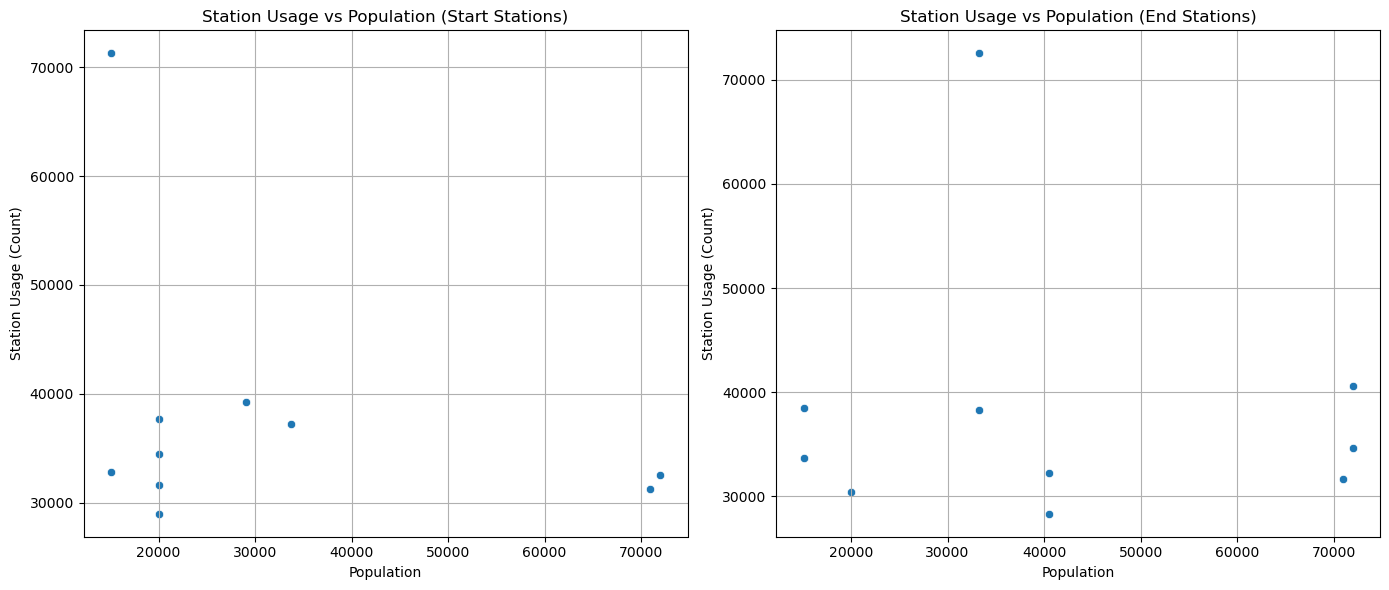

In [36]:
# Make a scatter plot of usage data vs. population
# Load data from JSON files
start_stations_df = pd.read_json('Top10StartStationsCopy.json')
end_stations_df = pd.read_json('Top10EndStationsCopy.json')

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Scatter plot for start stations
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.scatterplot(x='population', y='count', data=start_stations_df)
plt.title('Station Usage vs Population (Start Stations)')
plt.xlabel('Population')
plt.ylabel('Station Usage (Count)')
plt.grid(True)  # Enable grid

# Scatter plot for end stations
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.scatterplot(x='population', y='count', data=end_stations_df)
plt.title('Station Usage vs Population (End Stations)')
plt.xlabel('Population')
plt.ylabel('Station Usage (Count)')
plt.grid(True)  # Enable grid

# Show the plot
plt.tight_layout()
plt.show()

The weak negative correlation for both plots signifies that there is little to no correlation between population and usage in start or end stations. 

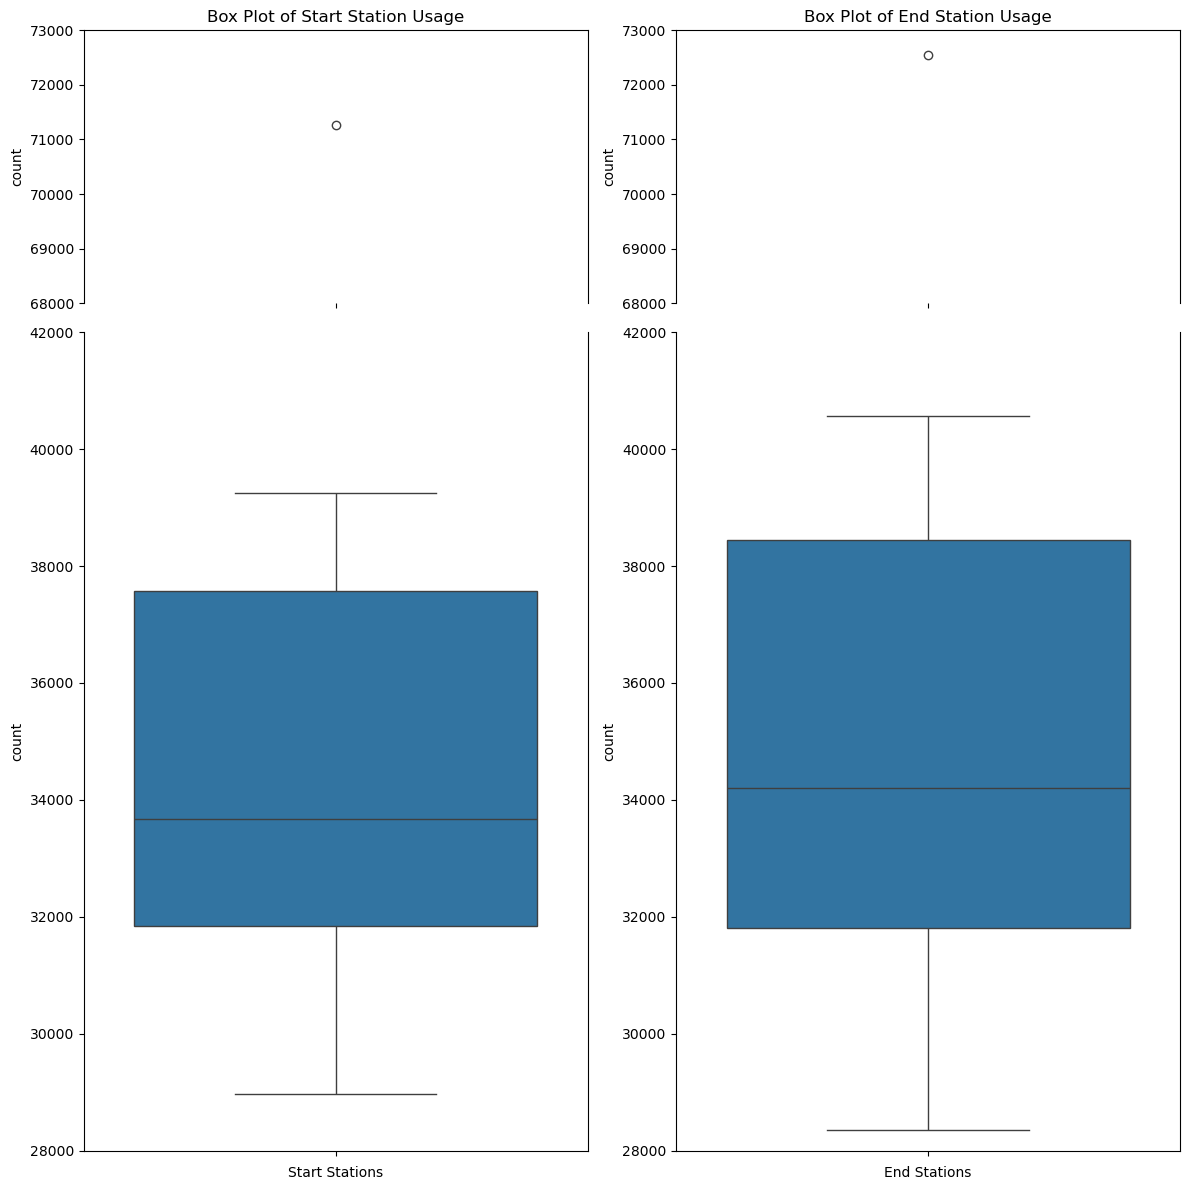

In [49]:
# Run a box plot for both .json files

# Load data from JSON files
start_stations_df = pd.read_json('Top10StartStationsCopy.json')
end_stations_df = pd.read_json('Top10EndStationsCopy.json')

# Set up the matplotlib figure
fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, gridspec_kw={'height_ratios': [1, 3]})

# Create upper and lower boxplots for start stations
sns.boxplot(y=start_stations_df['count'], ax=axs[0, 0])
sns.boxplot(y=start_stations_df['count'], ax=axs[1, 0])
axs[0, 0].set_ylim(68000, 73000)  # Upper part of y-axis range (adjust as needed)
axs[1, 0].set_ylim(28000, 42000)      # Lower part of y-axis range (adjust as needed)
axs[0, 0].set_title('Box Plot of Start Station Usage')
axs[0, 0].set_xlabel('')
axs[1, 0].set_xlabel('Start Stations')
axs[0, 0].spines['bottom'].set_visible(False)
axs[1, 0].spines['top'].set_visible(False)

# Create upper and lower boxplots for end stations
sns.boxplot(y=end_stations_df['count'], ax=axs[0, 1])
sns.boxplot(y=end_stations_df['count'], ax=axs[1, 1])
axs[0, 1].set_ylim(68000, 73000)  # Upper part of y-axis range (adjust as needed)
axs[1, 1].set_ylim(28000, 42000)      # Lower part of y-axis range (adjust as needed)
axs[0, 1].set_title('Box Plot of End Station Usage')
axs[0, 1].set_xlabel('')
axs[1, 1].set_xlabel('End Stations')
axs[0, 1].spines['bottom'].set_visible(False)
axs[1, 1].spines['top'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()

From the box plots, we can see that end stations have a larger interquartile range, with larger whiskers, meaning the data is spread out over a greater range of values than the start station data.  We can see that both start and end stations have an outlier.

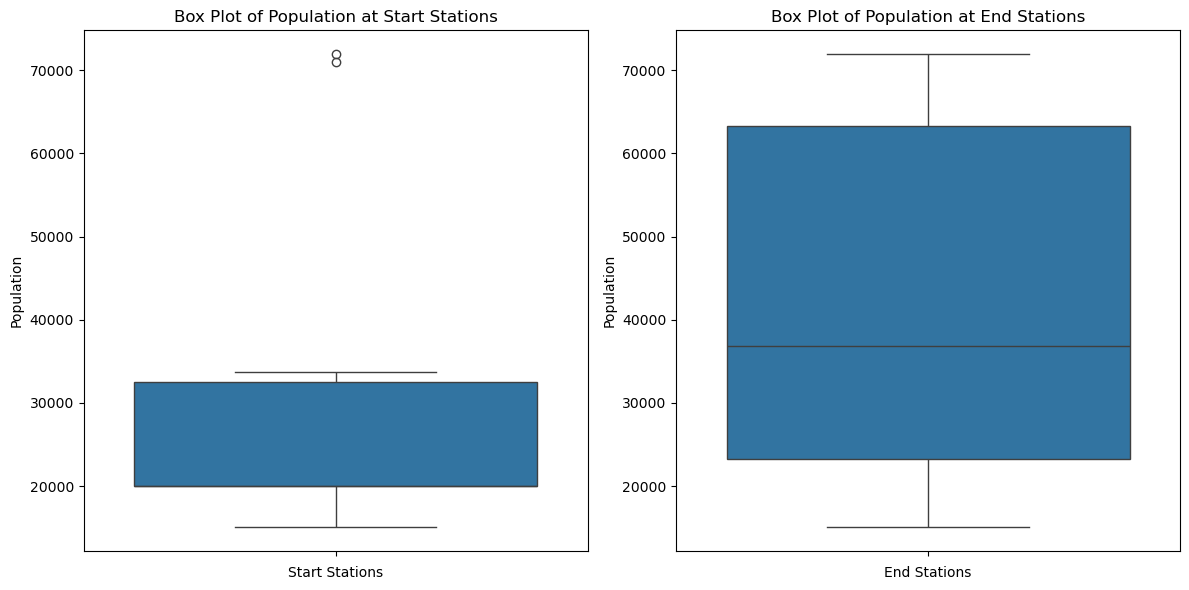

In [29]:
# Load data from JSON files
start_stations_df = pd.read_json('Top10StartStationsCopy.json')
end_stations_df = pd.read_json('Top10EndStationsCopy.json')

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Create a boxplot for population of Top10StartStationsCopy
plt.subplot(1, 2, 1)
sns.boxplot(y=start_stations_df['population'])
plt.title('Box Plot of Population at Start Stations')
plt.xlabel('Start Stations')
plt.ylabel('Population')

# Create a boxplot for population of Top10EndStationsCopy
plt.subplot(1, 2, 2)
sns.boxplot(y=end_stations_df['population'])
plt.title('Box Plot of Population at End Stations')
plt.xlabel('End Stations')
plt.ylabel('Population')

# Show the plot
plt.tight_layout()
plt.show()

We can see a clear difference in the population box plots between start stations and end stations.  Start stations have more of their data located below 40,000 people, whereas end stations have the range of data located from below 20,000 to above 70,000.  The start stations contain two outliers around 70,000 people, while the end station contains no outliers. 

In [21]:
# Run a t-test on Top 10 Start Stations (Copy) to test the hypothesis that the mean usage of bike stations in highly populated areas significantly differs from those in less populated areas
# We would think that with more people to use the bikes (i.e. the higher the population), the more the bikes would be used. However, it is important to note with such a small sample size compared to the median 
# that t-tests might not be extremely accurate. 

# Load data
file_path = 'Top10StartStationsCopy.json'
df = pd.read_json(file_path)

# Define the threshold
population_median_start = df['population'].median()

# Split the data into two groups
high_pop_start = df[df['population'] > population_median_start]
low_pop_start = df[df['population'] <= population_median_start]

# Perform a t-test
t_stat_start, p_value_start = ttest_ind(high_pop_start['count'], low_pop_start['count'], equal_var=False)

# Print the results
print(f"T-statistic: {t_stat_start}")
print(f"P-value: {p_value_start}")

# Interpret the results
alpha = 0.05  # significance level
if p_value_start < alpha:
    print("Reject the null hypothesis - there is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis - there is no significant difference between the means.")

T-statistic: -0.6547426556903535
P-value: 0.537645891006501
Fail to reject the null hypothesis - there is no significant difference between the means.


In [22]:
# Run a t-test on Top 10 End Stations (Copy) to test the hypothesis that the mean usage of bike stations in highly populated areas significantly differs from those in less populated areas
# We would think that with more people to use the bikes (i.e. the higher the population), the more the bikes would be used. 

# Load data
file_path2 = 'Top10EndStationsCopy.json'
df2 = pd.read_json(file_path2)

# Define the threshold
population_median_end = df2['population'].median()

# Split the data into two groups
high_pop_end = df2[df2['population'] > population_median_end]
low_pop_end = df2[df2['population'] <= population_median_end]

# Perform a t-test
t_stat_end, p_value_end = ttest_ind(high_pop_end['count'], low_pop_end['count'], equal_var=False)

# Print the results
print(f"T-statistic: {t_stat_end}")
print(f"P-value: {p_value_end}")

# Interpret the results
alpha = 0.05  # significance level
if p_value_end < alpha:
    print("Reject the null hypothesis - there is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis - there is no significant difference between the means.")

T-statistic: -1.1671806653275771
P-value: 0.30041723845463814
Fail to reject the null hypothesis - there is no significant difference between the means.


In [23]:
mongo.close()